In [1]:
# Import Necessary Libraries

import cv2
import numpy as np 
import matplotlib.pyplot as plt
import time

In [2]:
# Path to video  
video_path = "80269-572838304_medium.mp4"
video = cv2.VideoCapture(video_path)

# read only the first frame for drawing a rectangle for the desired object
ret,frame = video.read()

# I am giving  big random numbers for x_min and y_min because if you initialize them as zeros whatever coordinate you go minimum will be zero 
x_min,y_min,x_max,y_max=36000,36000,0,0

#print(ret)
#print(frame)




In [3]:
def coordinat_chooser(event,x,y,flags,param):
    global go , x_min , y_min, x_max , y_max

    # when you click the right button, it will provide coordinates for variables
    if event==cv2.EVENT_LBUTTONDOWN:
        
        # if current coordinate of x lower than the x_min it will be new x_min , same rules apply for y_min 
        x_min=min(x,x_min) 
        y_min=min(y,y_min)

         # if current coordinate of x higher than the x_max it will be new x_max , same rules apply for y_max
        x_max=max(x,x_max)
        y_max=max(y,y_max)

        # draw rectangle
        cv2.rectangle(frame,(x_min,y_min),(x_max,y_max),(0,255,0),1)


    """
        if you didn't like your rectangle (maybe if you made some misscliks),  reset the coordinates with the middle button of your mouse
        if you press the middle button of your mouse coordinates will reset and you can give a new 2-point pair for your rectangle
    """
    if event==cv2.EVENT_MBUTTONDOWN:
        print("reset coordinate  data")
        x_min,y_min,x_max,y_max=36000,36000,0,0

cv2.namedWindow('coordinate_screen')
# Set mouse handler for the specified window, in this case, "coordinate_screen" window
cv2.setMouseCallback('coordinate_screen',coordinat_chooser)

while True:
    cv2.imshow("coordinate_screen",frame) # show only first frame 
    
    k = cv2.waitKey(5) & 0xFF # after drawing rectangle press ESC   
    if k == 27:
        cv2.destroyAllWindows()
        break

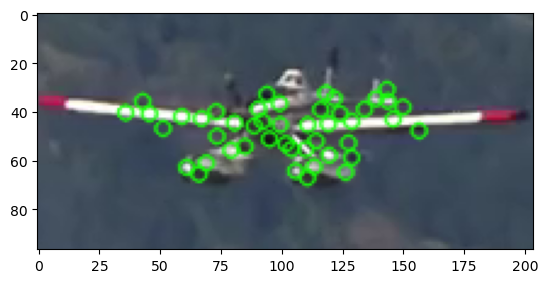

In [4]:
# take region of interest ( take inside of rectangle )
roi_image=frame[y_min+2:y_max-2,x_min+2:x_max-2]
roi_rgb=cv2.cvtColor(roi_image,cv2.COLOR_BGR2RGB)

# convert roi to grayscale, SIFT Algorithm works with grayscale images
roi_gray=cv2.cvtColor(roi_image,cv2.COLOR_BGR2GRAY) 

# Initialize the FAST detector and BRIEF descriptor extractor
akaze = cv2.AKAZE_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()


# detect keypoints
keypoints_1 = akaze.detect(roi_gray, None)
# descriptors
keypoints_1, descriptors_1 = brief.compute(roi_gray, keypoints_1)

# draw keypoints for visualizing
keypoints_image = cv2.drawKeypoints(roi_rgb, 
                                    keypoints_1, 
                                    outImage=None, 
                                    color=(23, 255, 10))
# display keypoints
plt.imshow(keypoints_image,cmap="gray")

In [5]:
# matcher object
bf = cv2.BFMatcher()

def detect_target_akaze(frame):
    # convert frame to gray scale 
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect keypoints using orb
    keypoints_2 = akaze.detect(frame_gray, None)

    # Compute descriptors using BRIEF
    keypoints_2, descriptors_2 = brief.compute(frame_gray, keypoints_2)

    """
    Compare the keypoints/descriptors extracted from the 
    first frame (from target object) with those extracted from the current frame.
    """
    if descriptors_2 is not None:
        matches = bf.match(descriptors_1, descriptors_2)
        
        if matches:
            # Initialize sums for x and y coordinates
            sum_x = 0
            sum_y = 0
            match_count = 0
            
            for match in matches:
                # .trainIdx gives keypoint index from current frame 
                train_idx = match.trainIdx
                
                # current frame keypoints coordinates
                pt2 = keypoints_2[train_idx].pt
                
                # Sum the x and y coordinates
                sum_x += pt2[0]
                sum_y += pt2[1]
                match_count += 1
            
            # Calculate average of the x and y coordinates
            avg_x = sum_x / match_count
            avg_y = sum_y / match_count
            
    return int(avg_x),int(avg_y)

In [6]:
# Initialize Kalman filter parameters
kalman = cv2.KalmanFilter(4, 2)   
 
kalman.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
kalman.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)
kalman.processNoiseCov = np.eye(4, dtype=np.float32) * 0.03  # Process noise
kalman.measurementNoiseCov = np.eye(2, dtype=np.float32) * 0.5  # Measurement noise

In [7]:
# Startcapturing the video from file
cap = cv2.VideoCapture(video_path)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Predict the new position of the ball
    predicted = kalman.predict()
    predicted_x, predicted_y = int(predicted[0]), int(predicted[1])
    predicted_dx, predicted_dy = predicted[2], predicted[3]  # Predicted velocity

    print(predicted_x, predicted_y )
    print(f"Predicted velocity: (dx: {predicted_dx}, dy: {predicted_dy})")

    
    # Detect the ball in the current frame
    ball_position = detect_target_akaze(frame)
    
    if ball_position:
        measured_x, measured_y = ball_position
        # Correct the Kalman Filter with the actual measurement
        kalman.correct(np.array([[np.float32(measured_x)], [np.float32(measured_y)]]))
        # Draw the detected ball
        cv2.circle(frame, (measured_x, measured_y), 6, (0, 255, 0), 2) # green --> correct position
    
    # Draw the predicted position (Kalman Filter result)
    cv2.circle(frame, (predicted_x, predicted_y), 8, (0, 0, 255), 2) # red --> predicted position

    # Show the frame
    cv2.imshow("Kalman Ball Tracking", frame)
    
    # Break on 'q' key press
    if cv2.waitKey(30) & 0xFF == ord('q'):  # 30 ms delay for smooth playback
        break

cap.release()
cv2.destroyAllWindows()

0 0
Predicted velocity: (dx: [0.], dy: [0.])
39 20
Predicted velocity: (dx: [0.], dy: [0.])
173 88
Predicted velocity: (dx: [33.81975], dy: [17.366901])
426 219
Predicted velocity: (dx: [95.61517], dy: [49.341072])
683 350
Predicted velocity: (dx: [138.62451], dy: [70.98315])
827 425
Predicted velocity: (dx: [140.11937], dy: [72.12043])
867 451
Predicted velocity: (dx: [115.57853], dy: [60.790356])
865 447
Predicted velocity: (dx: [87.20203], dy: [45.056725])
831 431
Predicted velocity: (dx: [57.77985], dy: [30.363325])
794 409
Predicted velocity: (dx: [35.04443], dy: [17.754831])
750 391
Predicted velocity: (dx: [15.782515], dy: [9.086208])
719 376
Predicted velocity: (dx: [4.4544783], dy: [3.259004])
699 366
Predicted velocity: (dx: [-1.5107232], dy: [-0.05921738])
679 361
Predicted velocity: (dx: [-5.9402933], dy: [-1.2863109])
665 358
Predicted velocity: (dx: [-7.881422], dy: [-1.6510984])
653 357
Predicted velocity: (dx: [-8.821214], dy: [-1.3769715])
650 357
Predicted velocity: (